# Εργασία 3

## Α. Ομαδοποίηση χειρόγραφων ψηφίων της MNIST

Σκοπός της εργασίας είναι η ομαδοποίηση των χειρόγραφων ψηφίων της MNIST. Πρώτα γίνεται μείωση διάστασης δεδομένων βασισμένη σε φασματική ανάλυση γράφου στις 2 διαστάσεις και ακολούθως ομαδοποίηση με spectral clustering.

### 1. Preprocessing

Τα δεδομένα περιέχονται στο αρχείο mnist_all.mat. Το διάβασμα του αρχείου γίνεται με την συνάρτηση scipy.io.loadmat η οποία επιστρέφει ένα dictionary το οποίο έχει κλειδια τα 'train0', 'train1', 'train2',... και 'test0', 'test1', 'test2',... και data τις εικόνες των αντίστοιχων ψηφίων.

In [1]:
import urllib.request
import numpy as np
import scipy.io
import os

np.random.seed(0)

url = 'https://cs.nyu.edu/~roweis/data/mnist_all.mat'
filename = 'mnist_all.mat'

if not os.path.exists(filename):
    print('Downloading file...')
    urllib.request.urlretrieve(url, filename)
    print('Done.')

mat = scipy.io.loadmat(filename)
mat.keys()

Οι εικόνες των ψηφίων έχουν μέγεθος 784 = 28x28.

In [2]:
digit = mat['train2'][0]
digit.shape

Παρακάτω φαίνονται οι εικόνες πέντε ψηφίων.

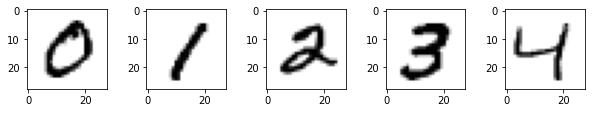

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 5
fig, axs = plt.subplots(1, n, figsize=(10, 10))
plt.subplots_adjust(wspace=0.5)
for i in range(n):
    digit = mat['train' + str(i)][0]
    digit = digit.reshape((28, 28))
    axs[i].imshow(digit, cmap=plt.cm.binary)
plt.show()

Οι είκονες και οι ετικέτες φορτώνονται σε numpy arrays. Για το training set επιλέγονται τα πρώτα 1000 παραδείγματα ανά ψηφίο, οπότε έχει μέγεθος 10000. Το test set έχει επίσης μέγεθος 10000. Γίνεται κανονικοποίηση στο διάστημα [0, 1], με διαίρεση με το 255 το οποίο είναι η μέγιστη τιμή της φωτεινότητας ενός pixel.

In [4]:
x_train, y_train, x_test, y_test = [], [], [], []

examples_per_digit = 1000

for key, data in mat.items():
    if 'train' in key:
        for x in data[:examples_per_digit]:
            x_train.append(x)
            num = int(key[-1])
            y_train.append(num)
    if 'test' in key:
        for x in data:
            x_test.append(x)
            num = int(key[-1])
            y_test.append(num)

x_train = np.array(x_train, dtype=np.double)
y_train = np.array(y_train, dtype=np.double)
x_test = np.array(x_test, dtype=np.double)
y_test = np.array(y_test, dtype=np.double)
x_train_original = x_train
x_test_original = x_test

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (10000, 784)
y_train.shape = (10000,)
x_test.shape = (10000, 784)
y_test.shape = (10000,)


In [5]:
x_train /= 255.
x_test /= 255.

print()
print('x_train is in [{}, {}]'.format(np.min(x_train), np.max(x_train)))
print('x_test is in [{}, {}]'.format(np.min(x_test), np.max(x_test)))


x_train is in [0.0, 1.0]
x_test is in [0.0, 1.0]


Παρακάτω βλέπουμε το ιστόγραμμα των ψηφίων στο training set. Κάθε ψηφίο αντιπροσωπεύεται απο 1000 εικόνες.

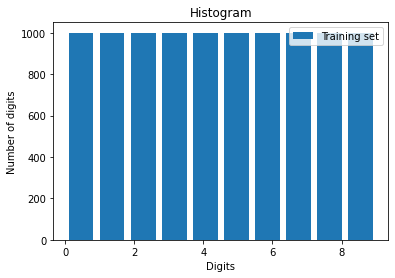

In [6]:
plt.hist(y_train, label='Training set', rwidth=0.8)
plt.title('Histogram')
plt.ylabel('Number of digits')
plt.xlabel('Digits')
plt.legend()
plt.show()

### 2. Embedding

Ακολουθεί εφαρμογή διάφορων embeddings: Spectral, Standard LLE, Modified LLE, Isomap και t-SNE με τα οποία μετασχηματίζονται τα δεδομένα σε χώρο δύο διαστάσεων.

embedding = Spectral, time = 35.7 sec
embedding = LLE, time = 58.9 sec
embedding = Isomap, time = 100.8 sec
embedding = t-SNE, time = 49.4 sec


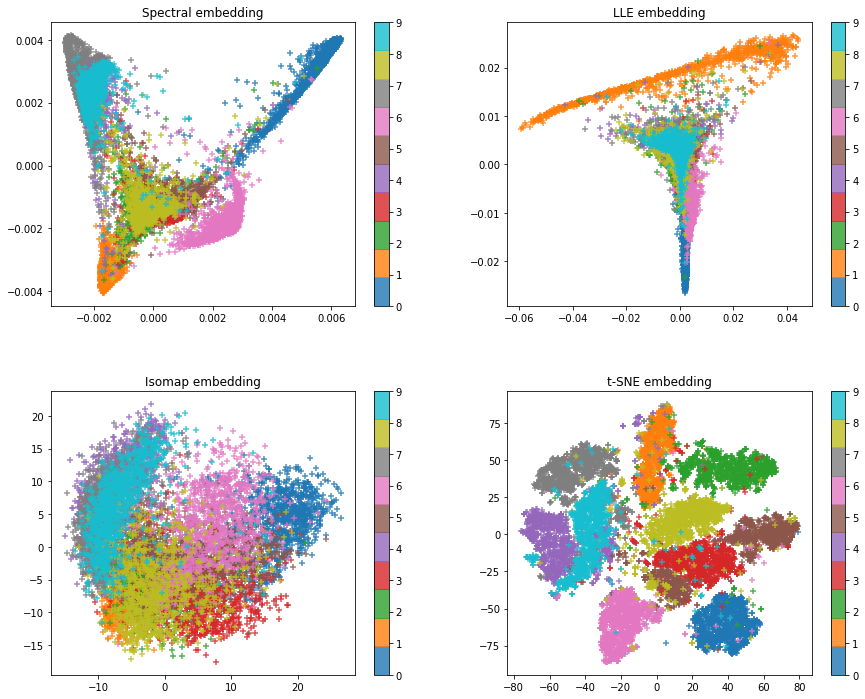

In [7]:
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
from time import time

embeddings = [
    ('Spectral', SpectralEmbedding(n_components=2, n_neighbors=20, random_state=0, n_jobs=-1)),
    ('LLE', LocallyLinearEmbedding(n_components=2, n_neighbors=20, n_jobs=-1)),
    ('Isomap', Isomap(n_components=2, n_neighbors=20, n_jobs=-1)),
    ('t-SNE', TSNE(n_components=2, random_state=0, n_jobs=-1)),
]

plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3)

x_train_embedded_dict = {}

for i, (embedding_str, embedding) in enumerate(embeddings):
    t1 = time()
    x_train_embedded = embedding.fit_transform(x_train)
    t2 = time()
    x_train_embedded_dict[embedding_str] = x_train_embedded
    plt.subplot(2, 2, i+1)
    plt.title('{} embedding'.format(embedding_str))
    plt.scatter(x_train_embedded[:, 0], x_train_embedded[:, 1],
                c=y_train, cmap='tab10', marker='+', alpha=0.8)
    plt.colorbar()
    print('embedding = {}, time = {:.1f} sec'.format(embedding_str, t2-t1))
    
plt.show()

Επιλέγουμε να προχωρήσουμε με το t-SNE γιατί μας δίνει αρκετά καλά διαχωρισμένες ομάδες.

In [8]:
x_train_embedded = x_train_embedded_dict['t-SNE']

### 3. Algorithms

#### 3.1 MySpectralClustering

Ακολουθεί υλοποίηση Spectral Clustering. Αρχικά χτίζεται ο γράφος ομοιότητας με βάση τους k πλησιέστερους γείτονες. Απο αυτόν προκύπτει ο πίνακας γειτνίασης $G$. Αυτός ο πίνακας δεν είναι συμμετρικός γιατί αν ένα δείγμα Α έχει γείτονα το Β δεν σημαίνει ότι θα ισχύει και το αντίστροφο. Γίνεται συμμετρικός με τον ακόλουθο τύπο $S = \frac{1}{2} (G + G^T)$. Αυτός ο πίνακας είναι ο πίνακας ομοιότητας. Έπειτα πραγματοποιείται ιδιοανάλυση στον unnormalized και normalized laplacian matrix $L$. Τα ιδιοδιανύσματα αποτελούν τις στήλες του νέου πίνακα δειγμάτων τα οποία έχουν μετασχηματιστεί σε ένα νέο χώρο. Χρησιμοποιούνται ειδικές δομές και συναρτήσεις για αραιούς πίνακες. Στο τέλος πραγματοποιείται clustering με k-means.

In [9]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans

class MySpectralClustering(object):
    def __init__(self, n_clusters=8, n_components=None, n_neighbors=10,
                 normed=True, random_state=None, n_jobs=None):
        self.n_clusters = n_clusters
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.normed = normed
        self.random_state = random_state
        self.n_jobs = n_jobs
        
    def set_params(self, **params):
        if not params: return self
        self.n_clusters = params.get('n_clusters', self.n_clusters)
        self.n_components = params.get('n_clusters', self.n_components)
        self.n_neighbors = params.get('n_neighbors', self.n_neighbors)
        self.normed = params.get('normed', self.normed)
        self.random_state = params.get('random_state', self.random_state)
        self.n_jobs = params.get('n_jobs', self.n_jobs)
        return self
    
    def fit_predict(self, X):
        G = kneighbors_graph(X, n_neighbors=self.n_neighbors, n_jobs=self.n_jobs)
        S = 0.5*(G + G.T)
        L, d = scipy.sparse.csgraph.laplacian(S, normed=self.normed, return_diag=True)
            
        if self.n_components is None:
            self.n_components = self.n_clusters
        
        w, v = eigsh(L, self.n_components, sigma=0, which='LM')
        
        if self.normed:
            v /= np.sqrt(d).reshape(-1, 1)
        
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        labels = kmeans.fit_predict(v)
        
        return labels

### 4. Clustering

Εφαρμόζονται διάφοροι τύποι Spectral Clustering. Γίνεται ομαδοποίηση για n_clusters απο 2 έως 17. Για κάθε τιμή του n_clusters δίνονται διαγράμματα όπου φαίνονται οι διάφορες ομάδες που έχουν σχηματιστεί. Έπειτα δίνονται οι τιμές των Homogeneity, Completeness και V-measure. Η μετρική Homogeneity μας δείχνει κατά πόσο οι ομάδες περιέχουν δεδομένα τα οποία είναι μέλη μίας μόνο κλάσης. Η μετρική Completeness μας δείχνει κατά πόσο όλα τα δείγματα μιας ομάδας είναι μέλη της ίδιας κλάσης. Τέλος η μετρική V-measure είναι ο αρμονικός μέσος των Homogeneity και Completeness. Τα αποτελέσματα της ομαδοποίησης χρησιμοποιούνται για να γίνει κατηγοριοποίηση του test set με Nearest Class Centroid. Ως ετικέτα της ομάδας επιλέγεται η πιο συχνή ετικέτα. Μετά την κατηγοριοποίηση δίνονται οι μετρικές Accuracy, Precision, Recall, F1 και το Confusion Matrix.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestCentroid
from sklearn.utils import shuffle

all_results = {}

def do_the_clustering(clustering_str, clustering, X, y, verbose=0):
    all_n_clusters = range(2, 18)
    experiments_num = len(all_n_clusters)
    homogeneity = np.zeros(experiments_num)
    completeness = np.zeros(experiments_num)
    v_measure = np.zeros(experiments_num)
    times = np.zeros(experiments_num)
    accuracy = np.zeros(experiments_num)
    recall = np.zeros(experiments_num)
    precision = np.zeros(experiments_num)
    f1 = np.zeros(experiments_num)
    all_examples = []
    most_frequent_labels = []
    cm = None

    plt.subplots(8, 2, figsize=(15, 45))
    plt.subplots_adjust(hspace=0.3)
    
    for i, n_clusters in enumerate(all_n_clusters):
        clustering.set_params(n_clusters=n_clusters)
        t1 = time()
        y_pred = clustering.fit_predict(X)
        t2 = time()
        times[i] = t2 - t1
        homogeneity[i], completeness[i], v_measure[i] = homogeneity_completeness_v_measure(y, y_pred)        
        plt.subplot(8, 2, i+1)
        plt.title('n_clusters = {}'.format(n_clusters))
        plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='tab10', marker='+', alpha=0.8)
        plt.colorbar()
        if verbose > 0:
            print('n_clusters = {}, time = {:.1f} sec'.format(n_clusters, times[i]))
        
        y_train_new = np.copy(y_pred)       
        for label in range(n_clusters):
            indices = (y_pred == label)
            counts = np.bincount(y.astype(int)[indices])
            val = np.argmax(counts)
            y_train_new[indices] = val
            
            if n_clusters == 10:
                x_examples = x_train_original[y_pred == label]
                x_examples = shuffle(x_examples, random_state=0)
                all_examples.append(x_examples[:10])
                most_frequent_labels.append(val)
        
        clf = NearestCentroid()
        clf.fit(x_train, y_train_new)
        y_pred_test = clf.predict(x_test)
        accuracy[i] = accuracy_score(y_test, y_pred_test)
        precision[i] = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
        recall[i] = recall_score(y_test, y_pred_test, average='weighted')
        f1[i] = f1_score(y_test, y_pred_test, average='weighted')
        
        if n_clusters == 10:
            cm = confusion_matrix(y_test, y_pred_test)
 
    plt.show()
    
    results = {
        'all_n_clusters': all_n_clusters,
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure,
        'times': times,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'times': times,
        'cm': cm,
        'all_examples': all_examples,
        'most_frequent_labels': most_frequent_labels,
    }
    
    all_results[clustering_str] = results
        
    return results

In [11]:
def plot_clustering_results(results):
    all_n_clusters = results['all_n_clusters']
    homogeneity = results['homogeneity']
    completeness = results['completeness']
    v_measure = results['v_measure']
    times = results['times']
    
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.4)
    
    plt.subplot(1, 2, 1)
    plt.title('Clustering scores')
    plt.plot(all_n_clusters, homogeneity, label='Homogeneity')
    plt.plot(all_n_clusters, completeness, label='Completeness')
    plt.plot(all_n_clusters, v_measure, label='V-Measure')
    plt.ylabel('Score')
    plt.xlabel('n_clusters')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('Clustering time')
    plt.plot(all_n_clusters, times)
    plt.ylabel('Time (sec)')
    plt.xlabel('n_clusters')
    plt.show()

In [12]:
import seaborn as sns

def plot_classification_results(results):
    all_n_clusters = results['all_n_clusters']
    accuracy = results['accuracy']
    precision = results['precision']
    recall = results['recall']
    f1 = results['f1']
    cm = results['cm']
    
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(1, 2, 1)
    plt.title('Classification scores')
    plt.plot(all_n_clusters, accuracy, label='Accuracy')
    plt.plot(all_n_clusters, precision, label='Precision')
    plt.plot(all_n_clusters, recall, label='Recall')
    plt.plot(all_n_clusters, f1, label='F1')
    plt.ylabel('Score')
    plt.xlabel('n_clusters')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('Confusion matrix for n_clusters = 10')
    sns.heatmap(cm, cmap="Oranges")
    plt.show()

In [13]:
from IPython.display import display, HTML
import pandas as pd

def display_scores(results):
    all_n_clusters = results['all_n_clusters']
    homogeneity = results['homogeneity']
    completeness = results['completeness']
    v_measure = results['v_measure']
    accuracy = results['accuracy']
    precision = results['precision']
    recall = results['recall']
    f1 = results['f1']
    times = results['times']
    
    df = pd.DataFrame(list(zip(all_n_clusters, homogeneity, completeness, v_measure,
                           accuracy, precision, recall, f1, times)),
                  columns=('n_clusters', 'Homogeneity', 'Completeness', 'V-Measure',
                           'Accuracy', 'Precision', 'Recall', 'F1', 'Clustering Time (sec)'))
    display(HTML(df.to_html(index=False)))

In [14]:
def display_final_scores(all_results, n_clusters):
    homogeneity, completeness, v_measure = [], [], []
    accuracy, precision, recall, f1 = [], [], [], []
    times = []

    clustering_strs = [
        'My Unnormalized Spectral Clustering',
        'My Normalized Spectral Clustering',
        'Normalized Spectral Clustering',
    ]
    
    index = n_clusters-2

    for clustering_str in clustering_strs:
        results = all_results[clustering_str]
        homogeneity.append(results['homogeneity'][index])
        completeness.append(results['completeness'][index])
        v_measure.append(results['v_measure'][index])
        accuracy.append(results['accuracy'][index])
        precision.append(results['precision'][index])
        recall.append(results['recall'][index])
        f1.append(results['f1'][index])
        times.append(results['times'][index])

    df = pd.DataFrame(list(zip(clustering_strs, homogeneity, completeness, v_measure,
                           accuracy, precision, recall, f1, times)),
                  columns=('Clustering', 'Homogeneity', 'Completeness', 'V-Measure',
                           'Accuracy', 'Precision', 'Recall', 'F1', 'Clustering Time (sec)'))
    display(HTML(df.to_html(index=False)))

In [15]:
def plot_clustering_examples(results):
    all_examples = results['all_examples']
    most_frequent_labels = results['most_frequent_labels']
    
    print('Clustering examples for n_clusters = 10')
    print()
    for label, examples in enumerate(all_examples):
        print('Examples for cluster {}. The most frequent label is {}.'
              .format(label, most_frequent_labels[label]))
        plt.subplots(1, 10, figsize=(15, 15))
        plt.subplots_adjust(wspace=0.4)
        for i, x_example in enumerate(examples):
            plt.subplot(1, 10, i+1)
            digit = x_example.reshape((28, 28))
            plt.imshow(digit, cmap=plt.cm.binary)
        plt.show()

#### 4.1 My Unnormalized Spectral Clustering

Πραγματοποιείται ομαδοποίηση Spectral Clustering χρησιμοποιώντας τον unnormalized laplacian matrix $L = D - S$.

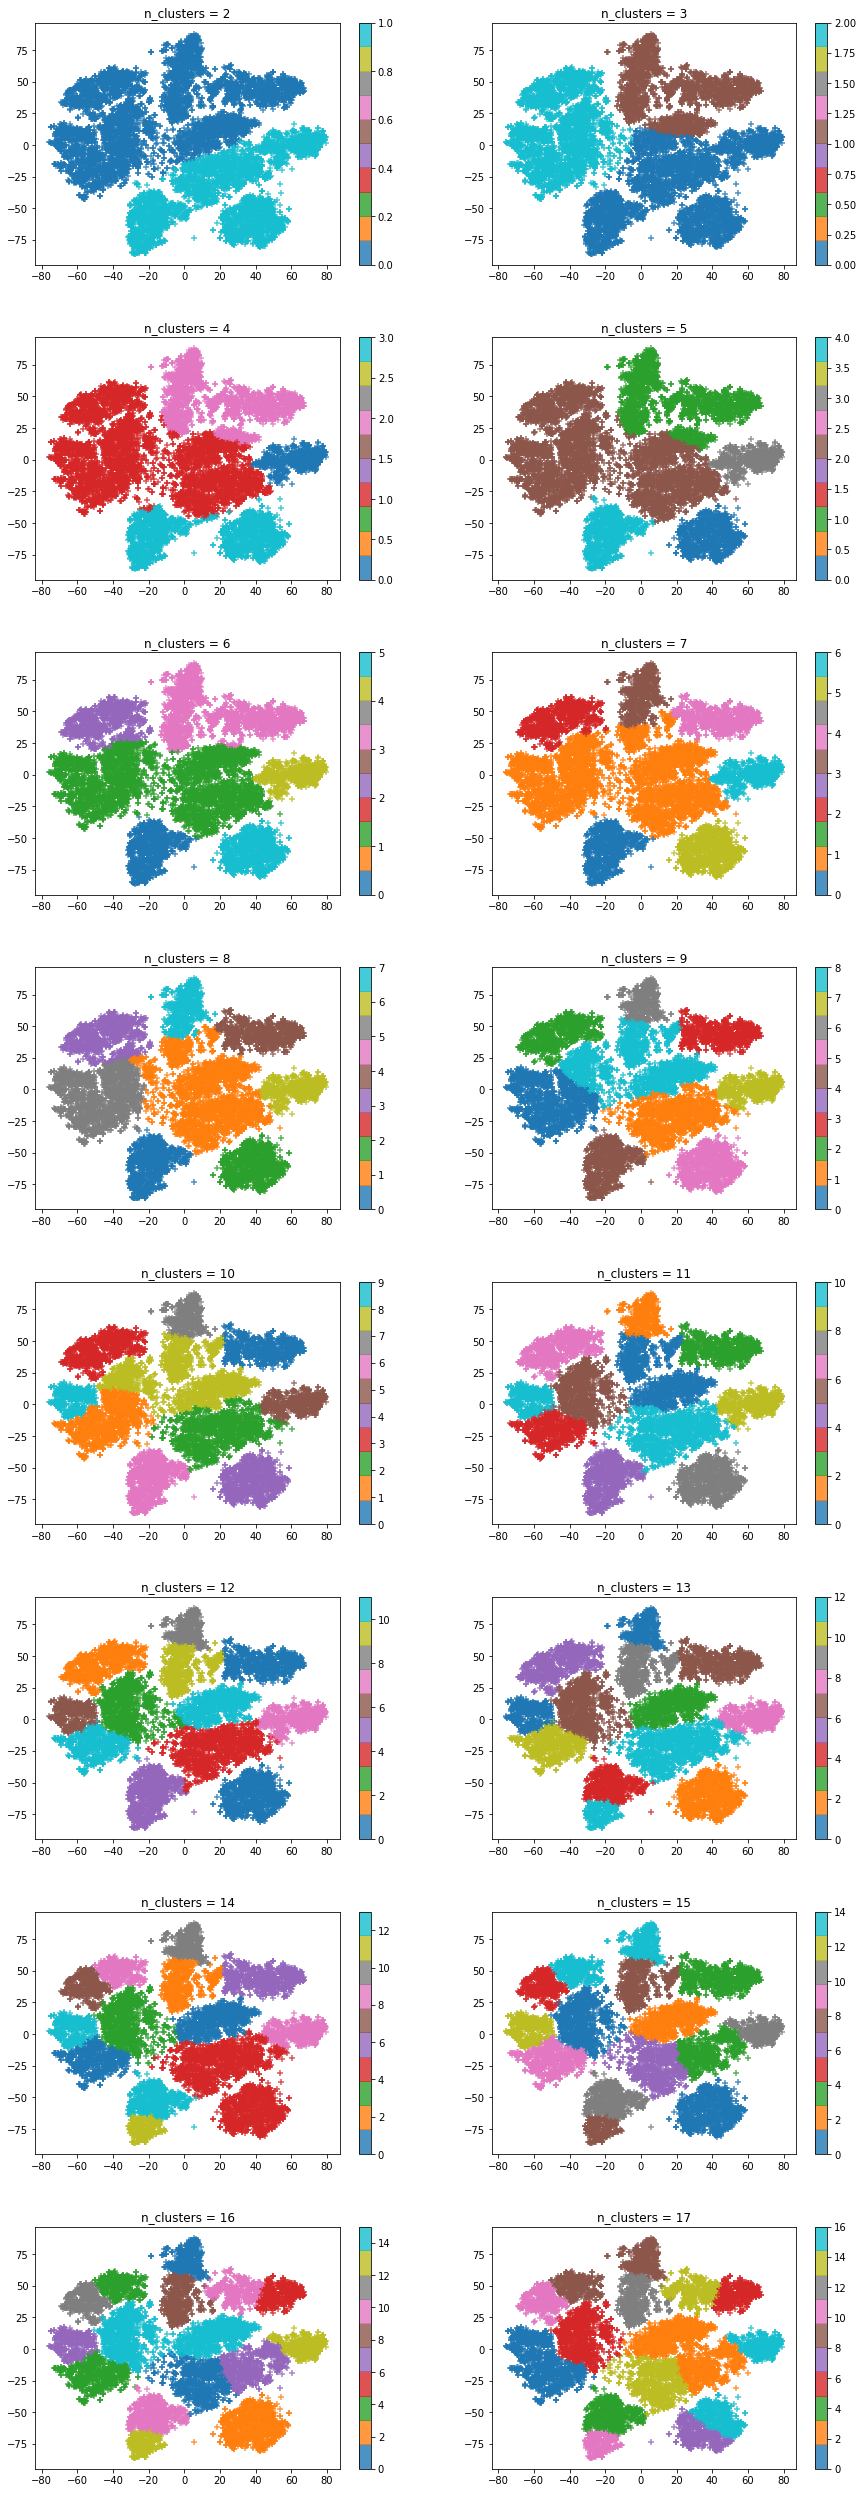

In [16]:
clustering = MySpectralClustering(n_neighbors=20, normed=False, random_state=0, n_jobs=-1)

results = do_the_clustering('My Unnormalized Spectral Clustering', clustering, x_train_embedded, y_train)

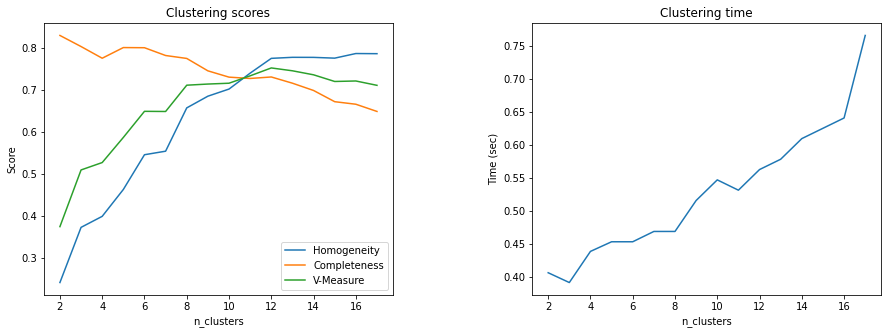

In [17]:
plot_clustering_results(results)

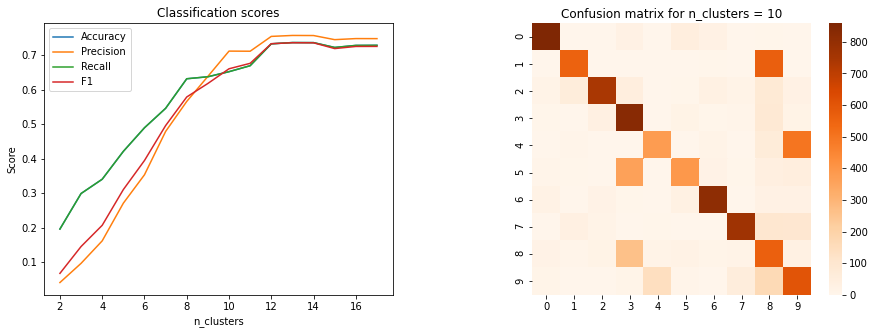

In [18]:
plot_classification_results(results)

In [19]:
display_scores(results)

n_clusters,Homogeneity,Completeness,V-Measure,Accuracy,Precision,Recall,F1,Clustering Time (sec)
2,0.242373,0.828838,0.375067,0.1965,0.041508,0.1965,0.068069,0.406127
3,0.373345,0.802508,0.509609,0.2994,0.097096,0.2994,0.145818,0.391274
4,0.399492,0.774782,0.527167,0.3408,0.162257,0.3408,0.207304,0.438421
5,0.463271,0.800059,0.586773,0.4215,0.271403,0.4215,0.310837,0.453018
6,0.545726,0.799715,0.648747,0.4899,0.353706,0.4899,0.395048,0.453018
7,0.554121,0.781221,0.648360,0.5462,0.479183,0.5462,0.496194,0.468640
8,0.656897,0.774268,0.710769,0.6319,0.566210,0.6319,0.579105,0.468640
9,0.684670,0.744831,0.713485,0.6377,0.638784,0.6377,0.618267,0.515504
10,0.701595,0.729882,0.715459,0.6524,0.712013,0.6524,0.660824,0.546746
11,0.739392,0.726741,0.733012,0.6697,0.711644,0.6697,0.676614,0.531125


Clustering examples for n_clusters = 10

Examples for cluster 0. The most frequent label is 2.


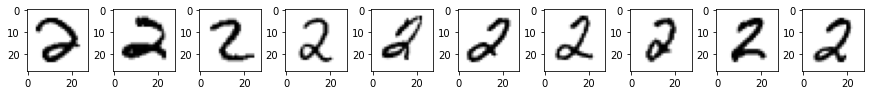

Examples for cluster 1. The most frequent label is 9.


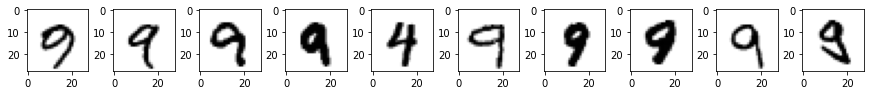

Examples for cluster 2. The most frequent label is 3.


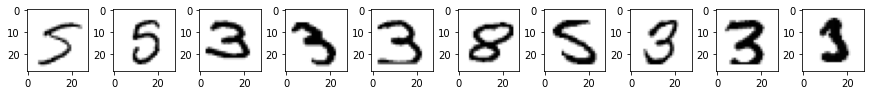

Examples for cluster 3. The most frequent label is 7.


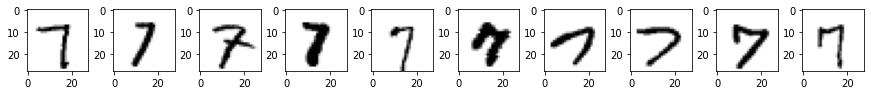

Examples for cluster 4. The most frequent label is 0.


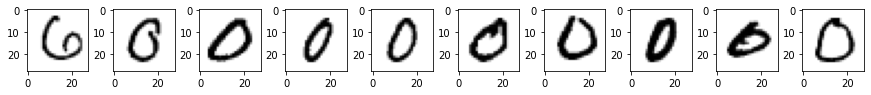

Examples for cluster 5. The most frequent label is 5.


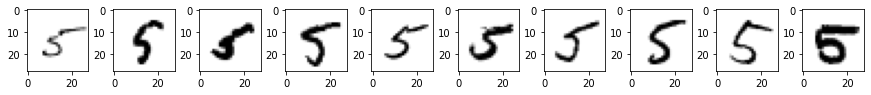

Examples for cluster 6. The most frequent label is 6.


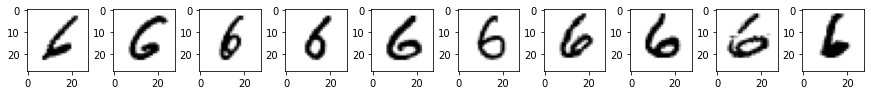

Examples for cluster 7. The most frequent label is 1.


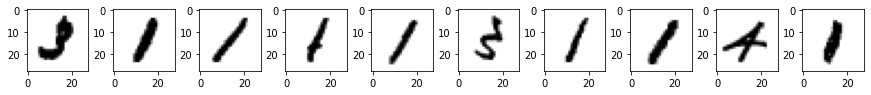

Examples for cluster 8. The most frequent label is 8.


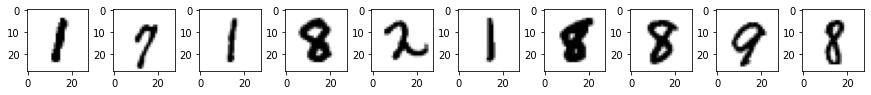

Examples for cluster 9. The most frequent label is 4.


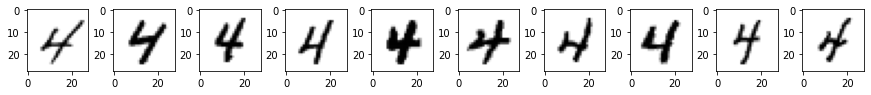

In [20]:
plot_clustering_examples(results)

#### 4.2 My Normalized Spectral Clustering

Πραγματοποιείται ομαδοποίηση Spectral Clustering χρησιμοποιώντας τον normalized laplacian matrix $L_{sym} = D^{-1/2}LD^{-1/2}$.

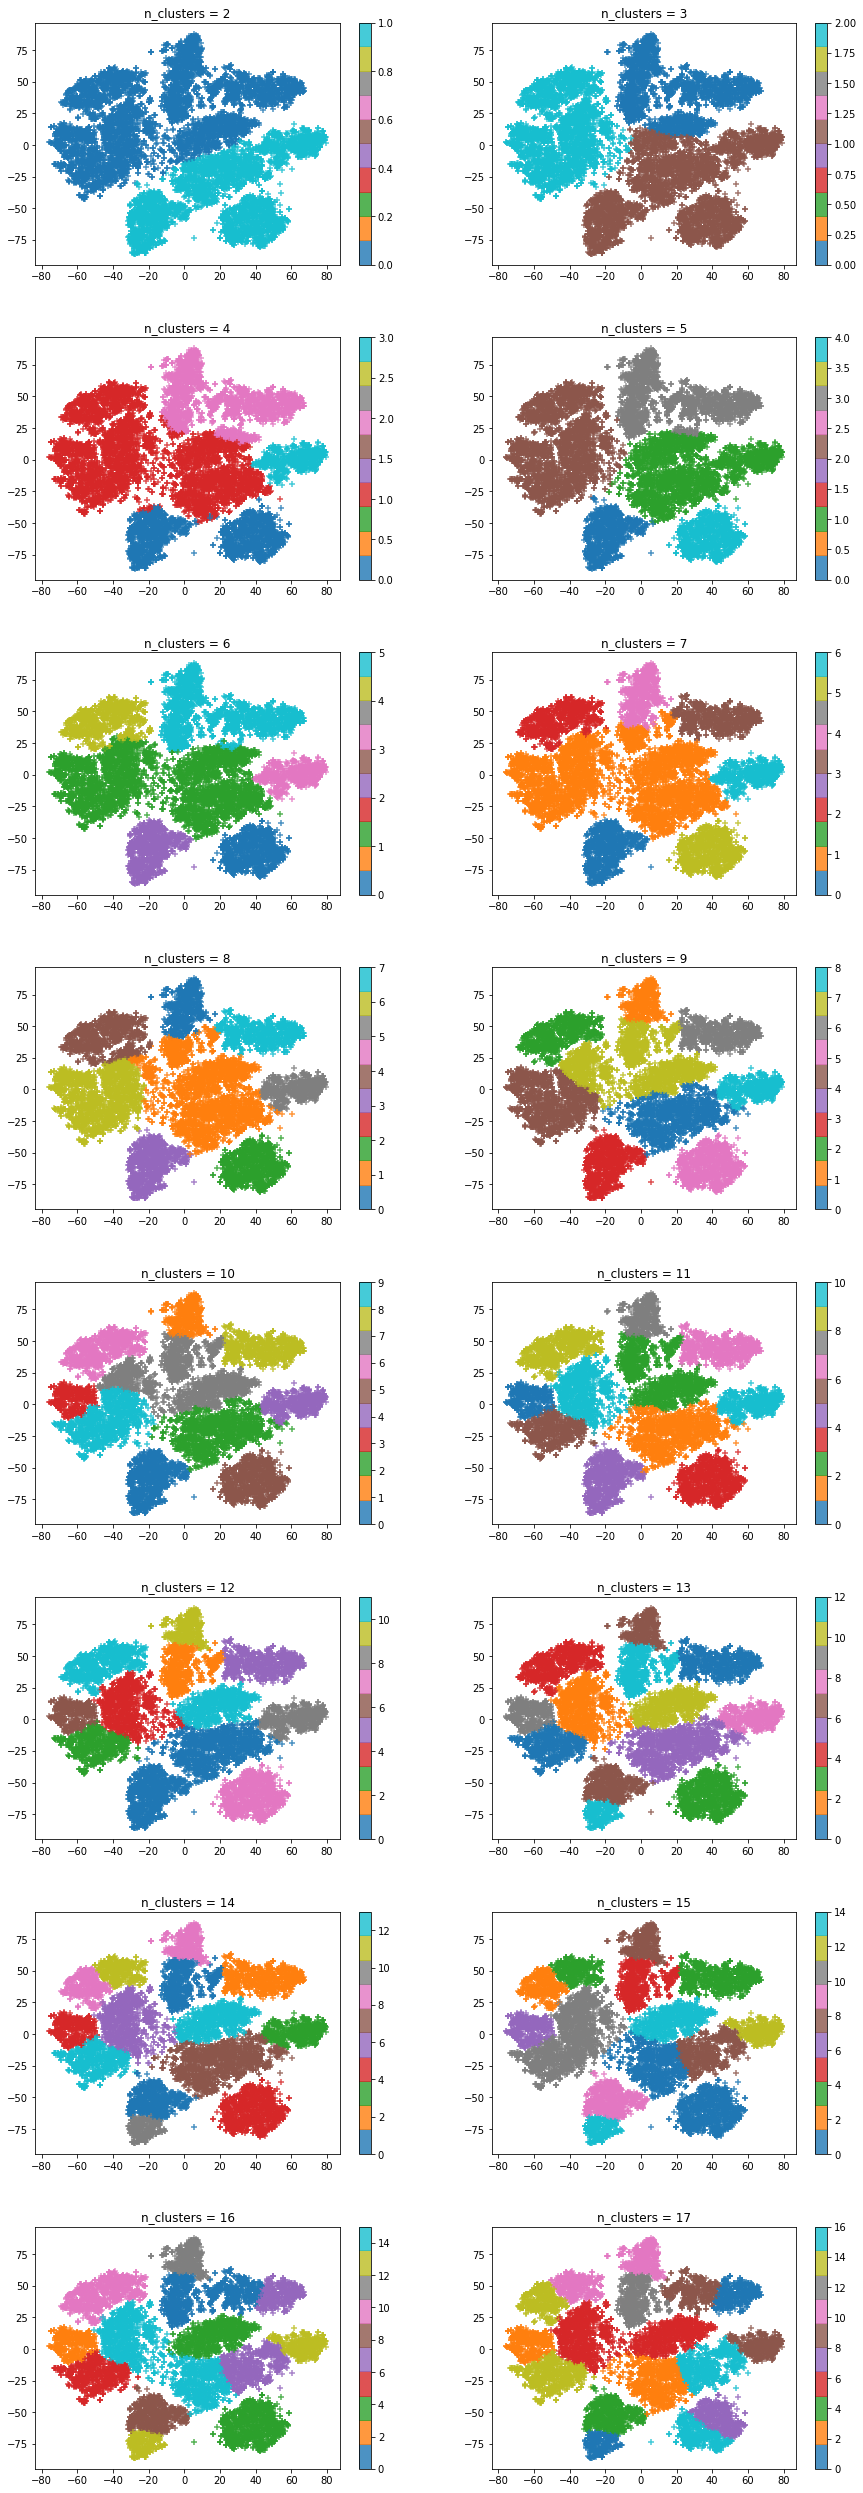

In [21]:
clustering = MySpectralClustering(n_neighbors=20, normed=True, random_state=0, n_jobs=-1)

results = do_the_clustering('My Normalized Spectral Clustering', clustering, x_train_embedded, y_train)

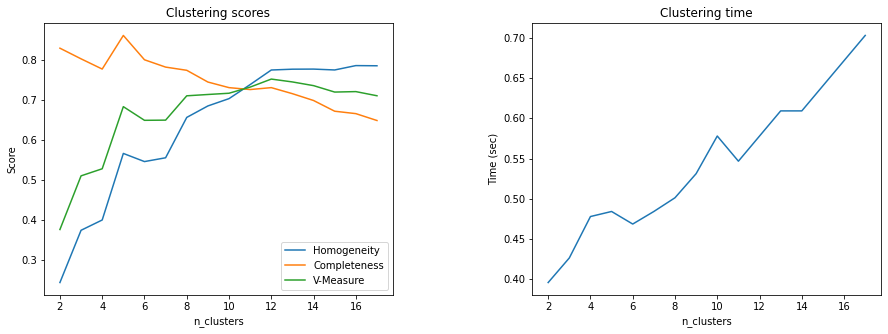

In [22]:
plot_clustering_results(results)

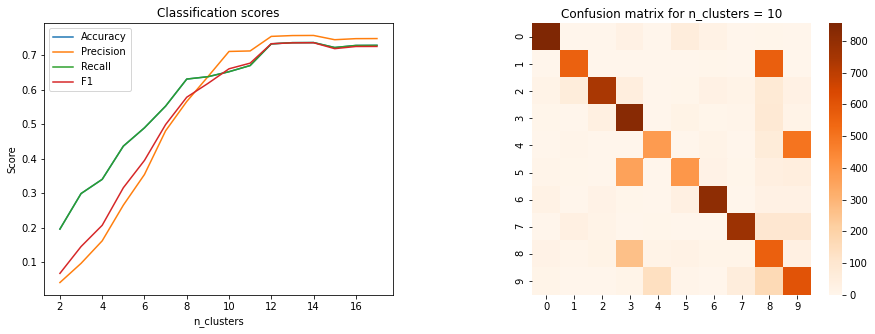

In [23]:
plot_classification_results(results)

In [24]:
display_scores(results)

n_clusters,Homogeneity,Completeness,V-Measure,Accuracy,Precision,Recall,F1,Clustering Time (sec)
2,0.242623,0.829790,0.375464,0.1965,0.041508,0.1965,0.068069,0.395972
3,0.373569,0.803095,0.509935,0.2994,0.097094,0.2994,0.145816,0.426519
4,0.399338,0.777502,0.527661,0.3406,0.162388,0.3406,0.207414,0.477971
5,0.566088,0.861706,0.683294,0.4368,0.265736,0.4368,0.316196,0.484262
6,0.545690,0.800776,0.649070,0.4899,0.354673,0.4899,0.395501,0.468641
7,0.555220,0.782404,0.649520,0.5528,0.481241,0.5528,0.499331,0.484262
8,0.656333,0.774392,0.710491,0.6312,0.566192,0.6312,0.578598,0.501305
9,0.685074,0.744986,0.713775,0.6380,0.637994,0.6380,0.618441,0.531243
10,0.703395,0.730952,0.716909,0.6525,0.711210,0.6525,0.660959,0.577990
11,0.738593,0.726152,0.732320,0.6704,0.712666,0.6704,0.677313,0.546746


Clustering examples for n_clusters = 10

Examples for cluster 0. The most frequent label is 6.


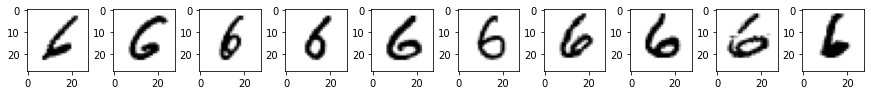

Examples for cluster 1. The most frequent label is 1.


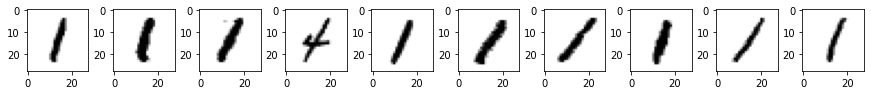

Examples for cluster 2. The most frequent label is 3.


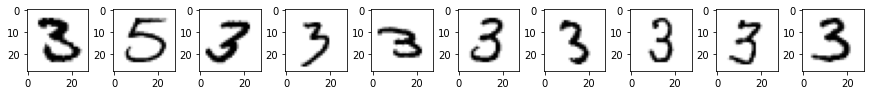

Examples for cluster 3. The most frequent label is 4.


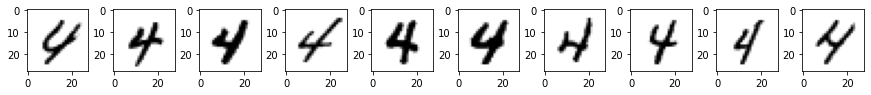

Examples for cluster 4. The most frequent label is 5.


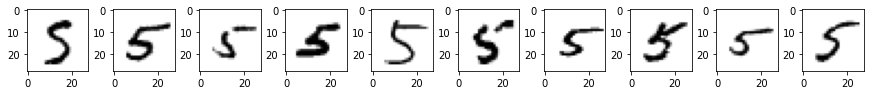

Examples for cluster 5. The most frequent label is 0.


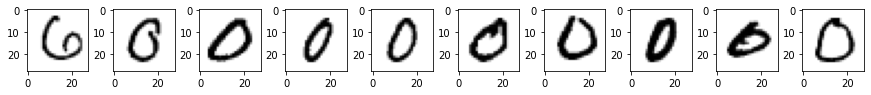

Examples for cluster 6. The most frequent label is 7.


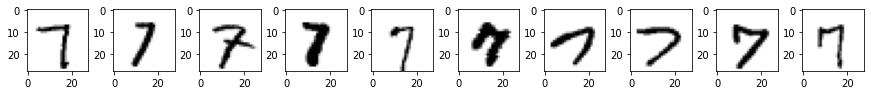

Examples for cluster 7. The most frequent label is 8.


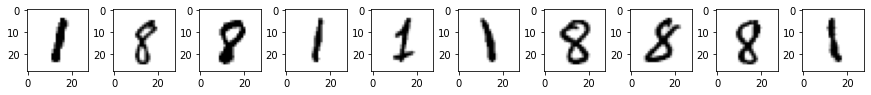

Examples for cluster 8. The most frequent label is 2.


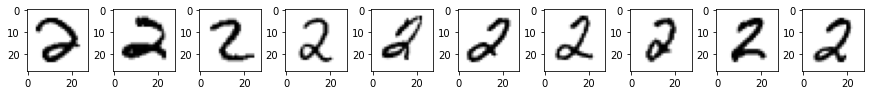

Examples for cluster 9. The most frequent label is 9.


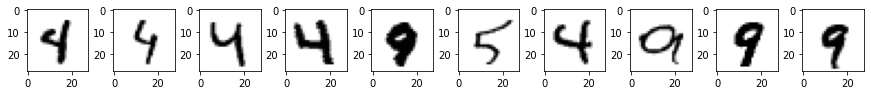

In [25]:
plot_clustering_examples(results)

#### 4.3 Normalized Spectral Clustering

Πραγματοποιείται ομαδοποίηση Spectral Clustering με τον αλγόριθμο sklearn.cluster.SpectralClustering ο οποίος χρησιμοποιεί τον normalized laplacian matrix $L_{sym} = D^{-1/2}LD^{-1/2}$.

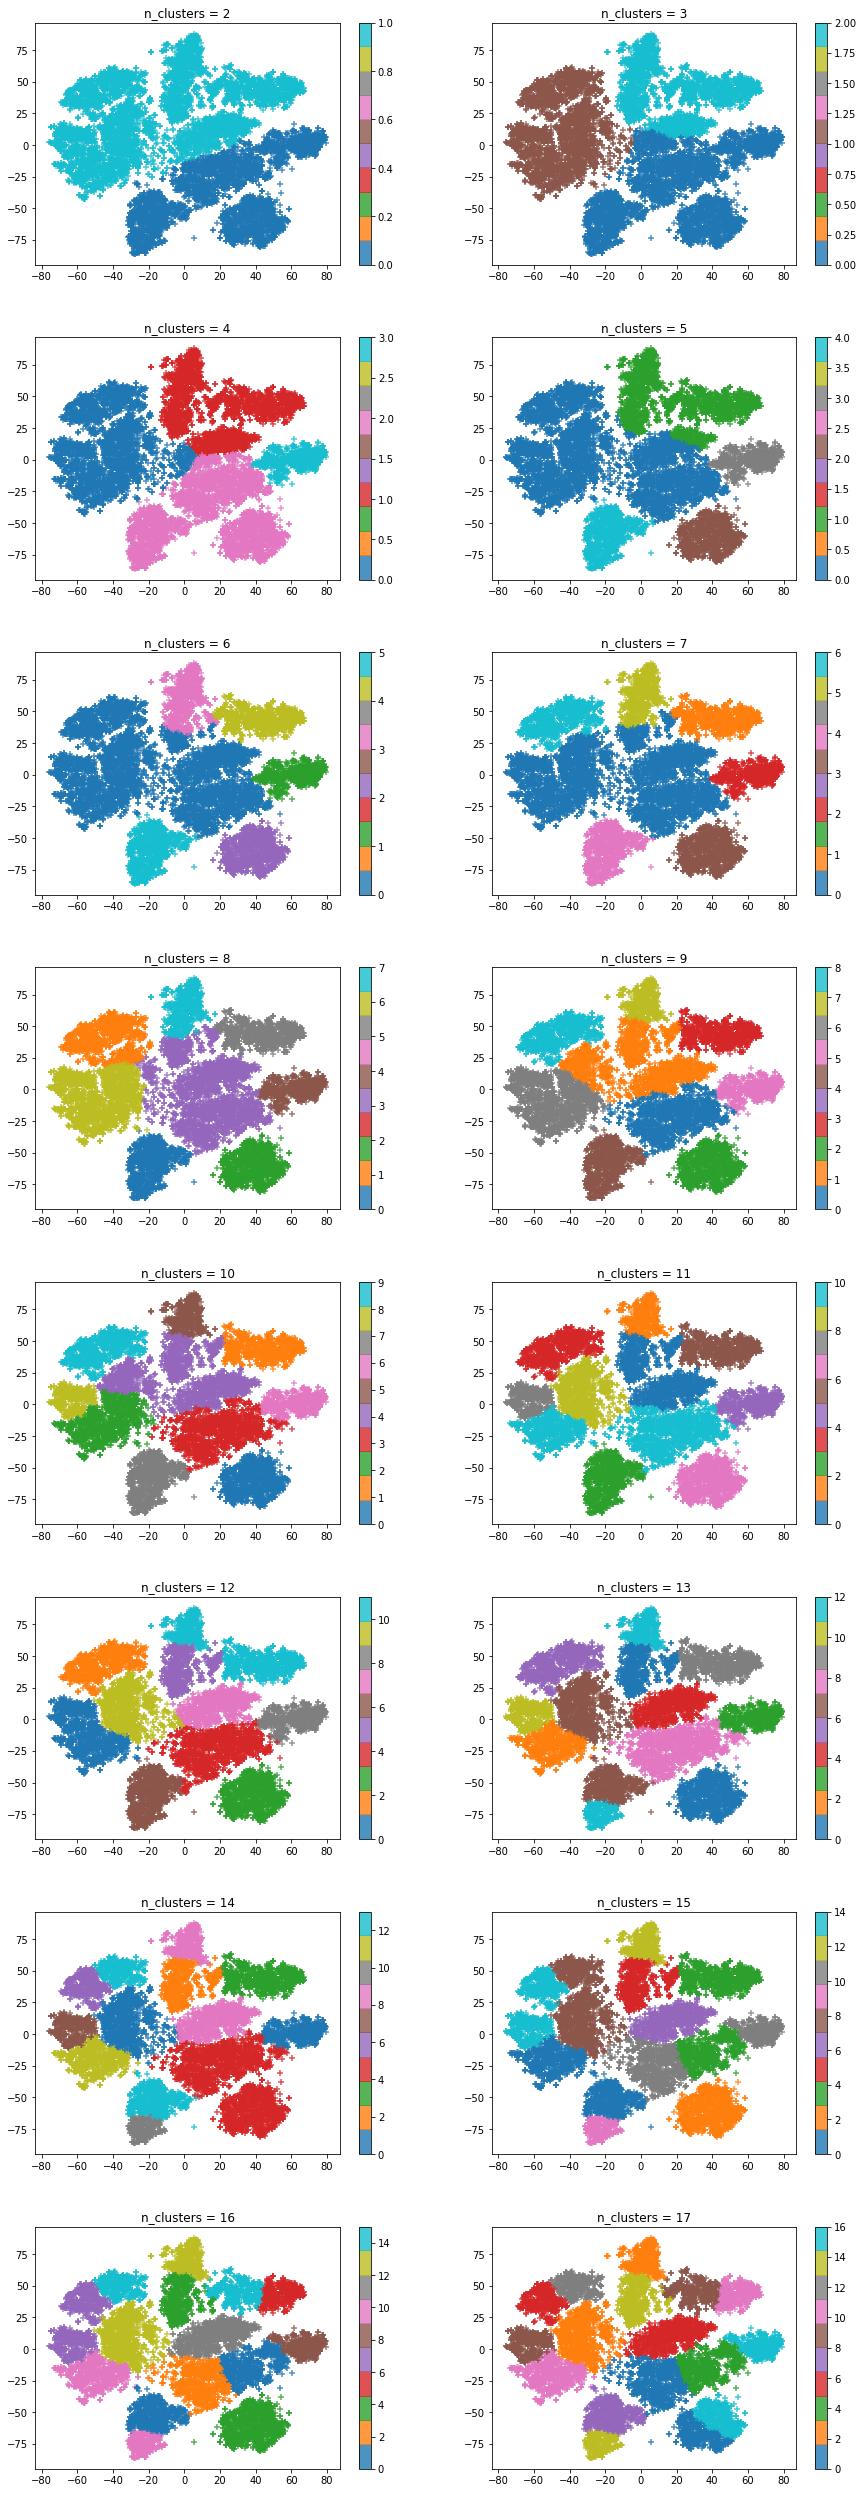

In [26]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=20, random_state=0, n_jobs=-1)

results = do_the_clustering('Normalized Spectral Clustering', clustering, x_train_embedded, y_train)

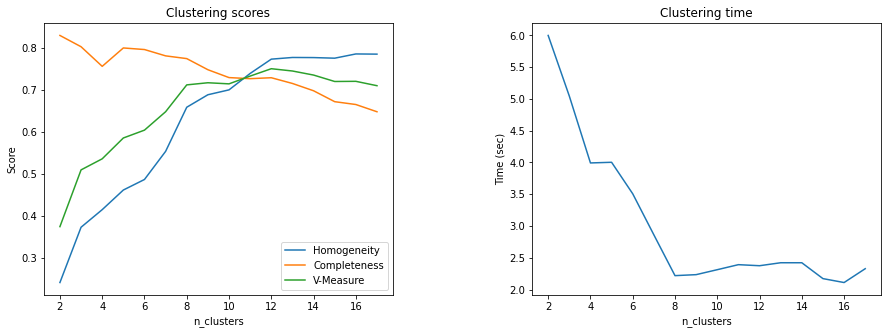

In [27]:
plot_clustering_results(results)

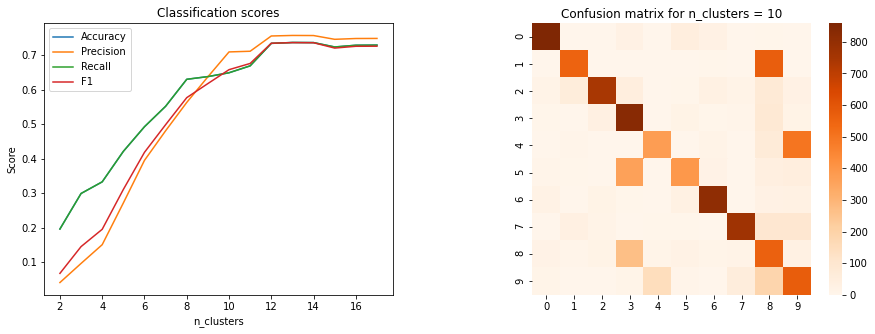

In [28]:
plot_classification_results(results)

In [29]:
display_scores(results)

n_clusters,Homogeneity,Completeness,V-Measure,Accuracy,Precision,Recall,F1,Clustering Time (sec)
2,0.242454,0.829163,0.375197,0.1965,0.041512,0.1965,0.068073,6.000511
3,0.373757,0.802366,0.509964,0.2994,0.096836,0.2994,0.145593,5.045886
4,0.415511,0.755806,0.536227,0.3331,0.151122,0.3331,0.195679,3.992862
5,0.462109,0.799466,0.585681,0.4213,0.271918,0.4213,0.311012,4.003318
6,0.487150,0.795712,0.604322,0.4927,0.395308,0.4927,0.418565,3.507443
7,0.553902,0.780690,0.648027,0.5519,0.480973,0.5519,0.498647,2.860807
8,0.658695,0.774173,0.711781,0.6301,0.563077,0.6301,0.576935,2.218231
9,0.688348,0.747796,0.716842,0.6379,0.637306,0.6379,0.617715,2.233852
10,0.699947,0.729094,0.714223,0.6490,0.709355,0.6490,0.657967,2.311959
11,0.738953,0.726538,0.732693,0.6690,0.711297,0.6690,0.675959,2.391075


Clustering examples for n_clusters = 10

Examples for cluster 0. The most frequent label is 0.


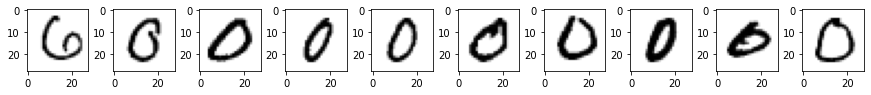

Examples for cluster 1. The most frequent label is 2.


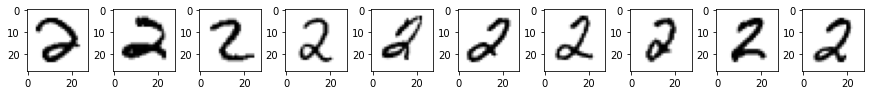

Examples for cluster 2. The most frequent label is 9.


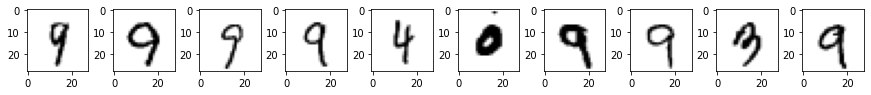

Examples for cluster 3. The most frequent label is 3.


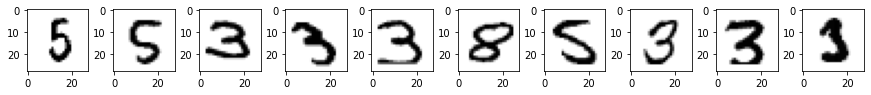

Examples for cluster 4. The most frequent label is 8.


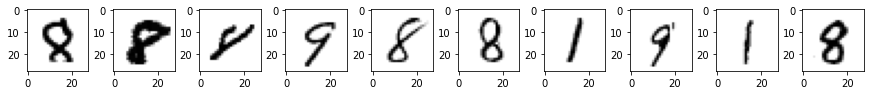

Examples for cluster 5. The most frequent label is 1.


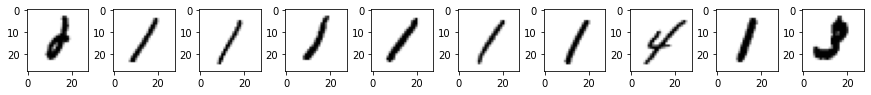

Examples for cluster 6. The most frequent label is 5.


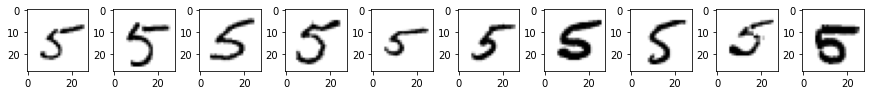

Examples for cluster 7. The most frequent label is 6.


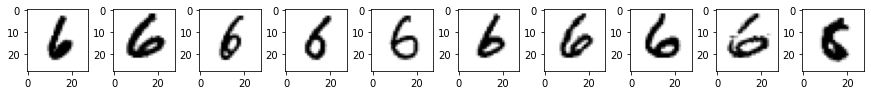

Examples for cluster 8. The most frequent label is 4.


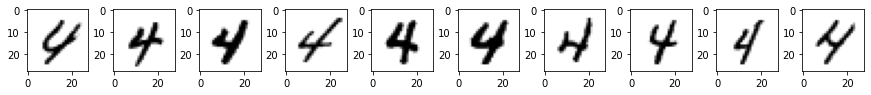

Examples for cluster 9. The most frequent label is 7.


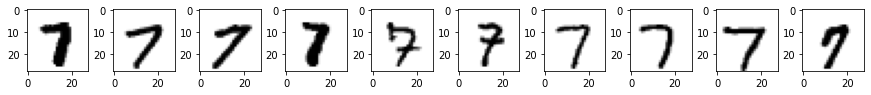

In [30]:
plot_clustering_examples(results)

### 5. Σύγκριση αποτελεσμάτων για n_clusters = 10

Ακολουθεί συνοπτικός πίνακας των clustering και classification scores για n_clusters = 10.

In [31]:
display_final_scores(all_results, n_clusters=10)

Clustering,Homogeneity,Completeness,V-Measure,Accuracy,Precision,Recall,F1,Clustering Time (sec)
My Unnormalized Spectral Clustering,0.701595,0.729882,0.715459,0.6524,0.712013,0.6524,0.660824,0.546746
My Normalized Spectral Clustering,0.703395,0.730952,0.716909,0.6525,0.711210,0.6525,0.660959,0.577990
Normalized Spectral Clustering,0.699947,0.729094,0.714223,0.6490,0.709355,0.6490,0.657967,2.311959


Όλοι οι αλγόριθμοι έχουν παρόμοια αποτελέσματα με μόνη διαφορά μεταξύ του sklearn και των δικών μου υλοποίησεων για n_clusters μεταξύ 4 και 6. Με βάση τα διαγράμματα των clustering και classification scores η βέλτιστη τιμή του n_clusters είναι 12. Για n_clusters = 10 παρατηρείται σύγχιση μεταξύ των ψηφίων 1 και 8 και μεταξύ των ψηφίων 4 και 9.